In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "san_francisco" dataset
dataset_ref = client.dataset("san_francisco", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "bikeshare_trips" table
table_ref = dataset_ref.table("bikeshare_trips")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=10).to_dataframe()

Using Kaggle's public dataset BigQuery integration.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Cannot use bqstorage_client if max_results is set, reverting to fetching data with the tabledata.list endpoint.


,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type
0,944732,2618,2015-09-24 17:22:00+00:00,Mezes,83,2015-09-24 18:06:00+00:00,Mezes,83,653,94063,Customer
1,984595,5957,2015-10-25 18:12:00+00:00,Mezes,83,2015-10-25 19:51:00+00:00,Mezes,83,52,nil,Customer
2,984596,5913,2015-10-25 18:13:00+00:00,Mezes,83,2015-10-25 19:51:00+00:00,Mezes,83,121,nil,Customer
3,1129385,6079,2016-03-18 10:33:00+00:00,Mezes,83,2016-03-18 12:14:00+00:00,Mezes,83,208,94070,Customer
4,1030383,5780,2015-12-06 10:52:00+00:00,Mezes,83,2015-12-06 12:28:00+00:00,Mezes,83,44,94064,Customer
5,1102641,801,2016-02-23 12:25:00+00:00,Mezes,83,2016-02-23 12:39:00+00:00,Mezes,83,174,93292,Customer
6,969490,255,2015-10-13 19:02:00+00:00,Mezes,83,2015-10-13 19:07:00+00:00,Mezes,83,650,94063,Subscriber
7,1129386,6032,2016-03-18 10:33:00+00:00,Mezes,83,2016-03-18 12:13:00+00:00,Mezes,83,155,94070,Customer
8,947105,1008,2015-09-26 12:57:00+00:00,Mezes,83,2015-09-26 13:13:00+00:00,Mezes,83,157,94063,Subscriber
9,1011650,60,2015-11-16 18:54:00+00:00,Mezes,83,2015-11-16 18:55:00+00:00,Mezes,83,35,94124,Subscriber


In [3]:
# Query to count the (cumulative) number of trips per day
num_trips_query = """
                  WITH trips_by_day AS
                  (
                  SELECT DATE(start_date) AS trip_date,
                      COUNT(*) as num_trips
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE EXTRACT(YEAR FROM start_date) = 2015
                  GROUP BY trip_date
                  )
                  SELECT *,
                      SUM(num_trips) 
                          OVER (
                               ORDER BY trip_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
                               ) AS cumulative_trips
                      FROM trips_by_day
                  """

# Run the query, and return a pandas DataFrame
num_trips_result = client.query(num_trips_query).result().to_dataframe()
num_trips_result.head()

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,trip_date,num_trips,cumulative_trips
0,2015-03-12,1328,66361
1,2015-09-05,386,248568
2,2015-03-18,1319,72404
3,2015-02-12,1305,39731
4,2015-07-16,1382,194927


In [4]:
# Query to track beginning and ending stations on October 25, 2015, for each bike
start_end_query = """
                  SELECT bike_number,
                      TIME(start_date) AS trip_time,
                      FIRST_VALUE(start_station_id)
                          OVER (
                               PARTITION BY bike_number
                               ORDER BY start_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                               ) AS first_station_id,
                      LAST_VALUE(end_station_id)
                          OVER (
                               PARTITION BY bike_number
                               ORDER BY start_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                               ) AS last_station_id,
                      start_station_id,
                      end_station_id
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE DATE(start_date) = '2015-10-25' 
                  """

# Run the query, and return a pandas DataFrame
start_end_result = client.query(start_end_query).result().to_dataframe()
start_end_result.head()


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,bike_number,trip_time,first_station_id,last_station_id,start_station_id,end_station_id
0,581,12:41:00,77,73,77,60
1,581,12:56:00,77,73,60,73
2,284,06:54:00,39,76,39,76
3,312,09:04:00,71,76,71,39
4,312,12:40:00,71,76,39,76


<AxesSubplot:>

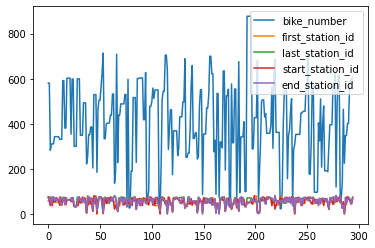

In [5]:
start_end_result.plot()